# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset merupakan harga historis saham Jakarta Stock Exchange Composite yang didapat dari [investing.com](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwidjo_Mq9eQAxX0UGwGHbRLNrAQFnoECBkQAQ&url=https%3A%2F%2Fwww.investing.com%2Findices%2Fidx-composite&usg=AOvVaw0j1k-9zsPPnMFPdLPTo0dv&opi=89978449)


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
import joblib

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [39]:
df = pd.read_csv('../Data Historis JKSE_raw.csv', parse_dates=['Tanggal'])
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,03/11/2025,"8.274,95","8.218,19","8.280,18","8.214,61","10,10B","1,36%"
1,31/10/2025,"8.163,88","8.202,52","8.215,55","8.144,08","24,54B","-0,25%"
2,30/10/2025,"8.184,06","8.176,36","8.231,88","8.145,60","32,67B","0,22%"
3,29/10/2025,"8.166,22","8.107,38","8.169,14","8.042,63","24,83B","0,91%"
4,28/10/2025,"8.092,63","8.144,42","8.151,33","8.039,85","28,29B","-0,30%"


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [40]:
#Data masih tersusun dari terbaru ke terlama, akan dibalik
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce', infer_datetime_format=True)
df = df.sort_values(by="Tanggal", ascending=True).reset_index(drop=True)
df.head()

C:\Users\angga\AppData\Local\Temp\ipykernel_1968\2530537045.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce', infer_datetime_format=True)


,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-02,"6.283,58","6.313,13","6.317,01","6.263,68","3,30B","-0,25%"
1,2020-01-03,"6.323,47","6.306,19","6.323,47","6.287,71","4,46B","0,63%"
2,2020-01-06,"6.257,40","6.293,50","6.300,44","6.252,64","4,14B","-1,04%"
3,2020-01-07,"6.279,35","6.272,22","6.284,89","6.246,13","3,94B","0,35%"
4,2020-01-08,"6.225,69","6.248,44","6.250,12","6.218,13","4,46B","-0,85%"


In [41]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     1410 non-null   datetime64[ns]
 1   Terakhir    1410 non-null   object        
 2   Pembukaan   1410 non-null   object        
 3   Tertinggi   1410 non-null   object        
 4   Terendah    1410 non-null   object        
 5   Vol.        1407 non-null   object        
 6   Perubahan%  1410 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 77.2+ KB
None


In [42]:
# Terlihat kolom masih bertipe object karena separator "," instead of "." maka dibersihkan
numeric_cols = ['Terakhir','Pembukaan','Tertinggi','Terendah']
for col in numeric_cols:
    # Replace ',' with '.' and remove any extra spaces
    df[col] = df[col].str.replace('.', '', regex=False)  # remove thousands sep if exists
    df[col] = df[col].str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [43]:
# Membersihkan "B"(stands for billion) pada kolom Vol.
def parse_volume(x):
    if pd.isna(x):
        return None
    x = x.replace('.', '').replace(',', '.').upper()
    if 'B' in x:
        return float(x.replace('B','')) * 1e9
    elif 'M' in x: # in case not all of them are "B"
        return float(x.replace('M','')) * 1e6
    elif 'K' in x:
        return float(x.replace('K','')) * 1e3
    else:
        return float(x)

df['Vol.'] = df['Vol.'].apply(parse_volume)


In [44]:
df['Perubahan%'] = df['Perubahan%'].str.replace('%','').str.replace(',','.', regex=False)
df['Perubahan%'] = pd.to_numeric(df['Perubahan%'], errors='coerce')

In [45]:
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-02,6283.58,6313.13,6317.01,6263.68,3.300000e+09,-0.25
1,2020-01-03,6323.47,6306.19,6323.47,6287.71,4.460000e+09,0.63
2,2020-01-06,6257.40,6293.50,6300.44,6252.64,4.140000e+09,-1.04
3,2020-01-07,6279.35,6272.22,6284.89,6246.13,3.940000e+09,0.35
4,2020-01-08,6225.69,6248.44,6250.12,6218.13,4.460000e+09,-0.85


In [46]:
print(df.describe())

                             Tanggal     Terakhir    Pembukaan    Tertinggi  \
count                           1410  1410.000000  1410.000000  1410.000000   
mean   2022-11-26 09:06:22.978723328  6618.694901  6622.661560  6659.359390   
min              2020-01-02 00:00:00  3937.630000  3937.630000  4123.560000   
25%              2021-06-17 06:00:00  6140.805000  6145.982500  6169.462500   
50%              2022-11-19 12:00:00  6825.800000  6829.980000  6865.345000   
75%              2024-05-14 18:00:00  7134.072500  7134.587500  7177.012500   
max              2025-11-03 00:00:00  8274.950000  8322.220000  8354.670000   
std                              NaN   802.177580   803.207617   800.788625   

          Terendah          Vol.   Perubahan%  
count  1410.000000  1.407000e+03  1410.000000  
mean   6578.923624  1.730949e+10     0.025170  
min    3911.720000  2.640000e+09    -7.900000  
25%    6103.377500  1.320500e+10    -0.487500  
50%    6796.465000  1.653000e+10     0.060000  


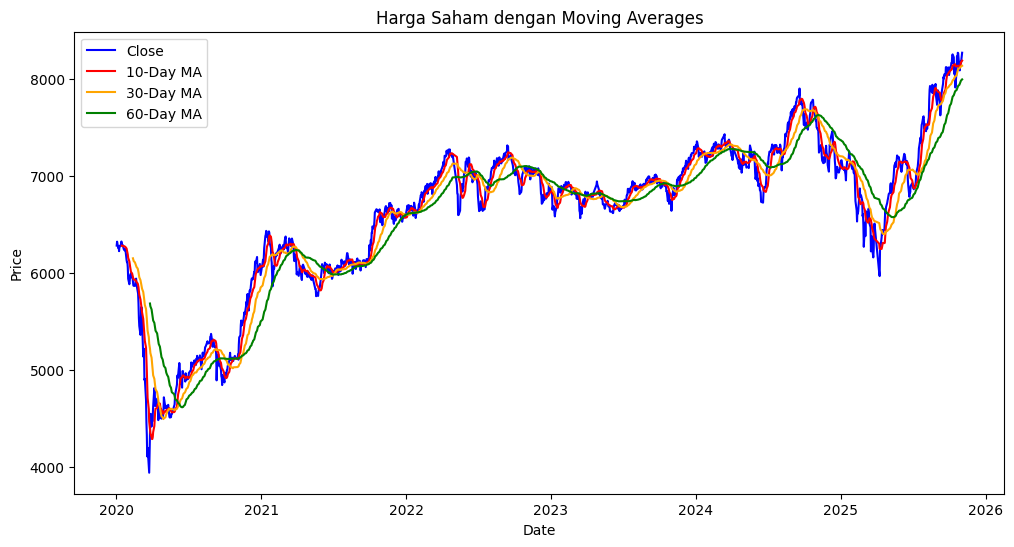

In [48]:
df['MA30'] = df['Terakhir'].rolling(30).mean()
df['MA60'] = df['Terakhir'].rolling(60).mean()
df['MA10'] = df["Terakhir"].rolling(10).mean()
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Terakhir'], label='Close', color='blue')
plt.plot(df['Tanggal'], df['MA10'], label='10-Day MA', color='red')
plt.plot(df['Tanggal'], df['MA30'], label='30-Day MA', color='orange')
plt.plot(df['Tanggal'], df['MA60'], label='60-Day MA', color='green')
plt.title('Harga Saham dengan Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


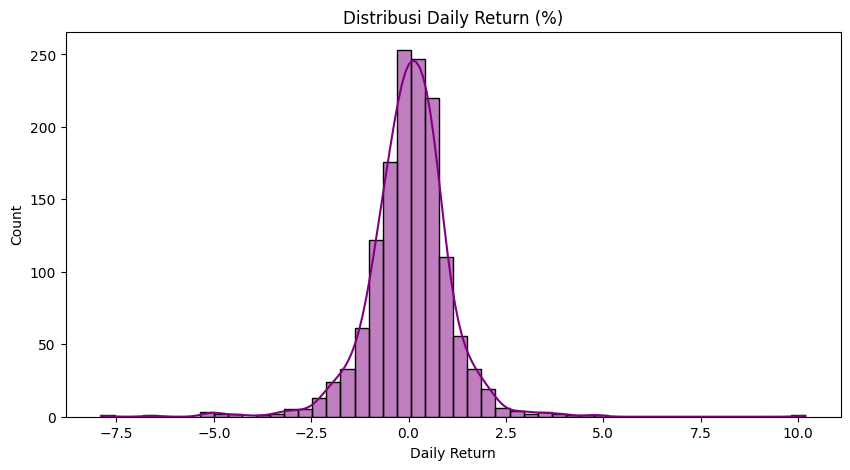

In [49]:
plt.figure(figsize=(10,5))
sns.histplot(df['Perubahan%'].dropna(), bins=50, kde=True, color='purple')
plt.title('Distribusi Daily Return (%)')
plt.xlabel('Daily Return')
plt.show()

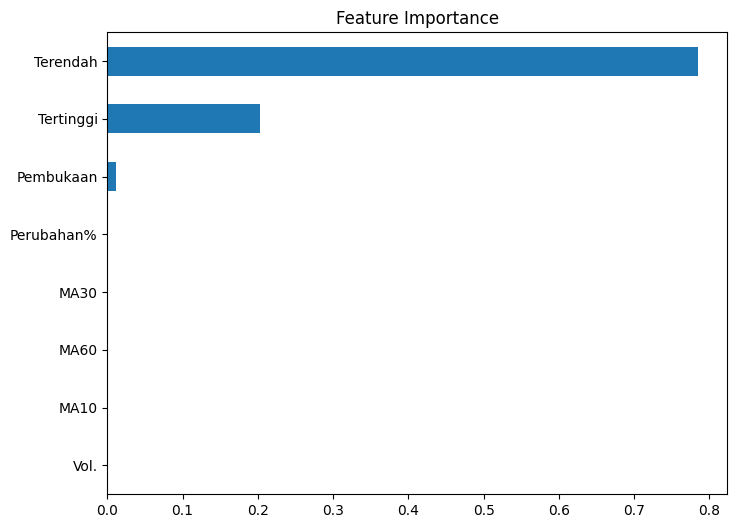

In [64]:
# Example: use all numeric columns except Date
X = df.drop(columns=['Tanggal', 'Terakhir'])
y = df['Terakhir']

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)

importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=True).plot(kind='barh', figsize=(8,6), title='Feature Importance')
plt.show()

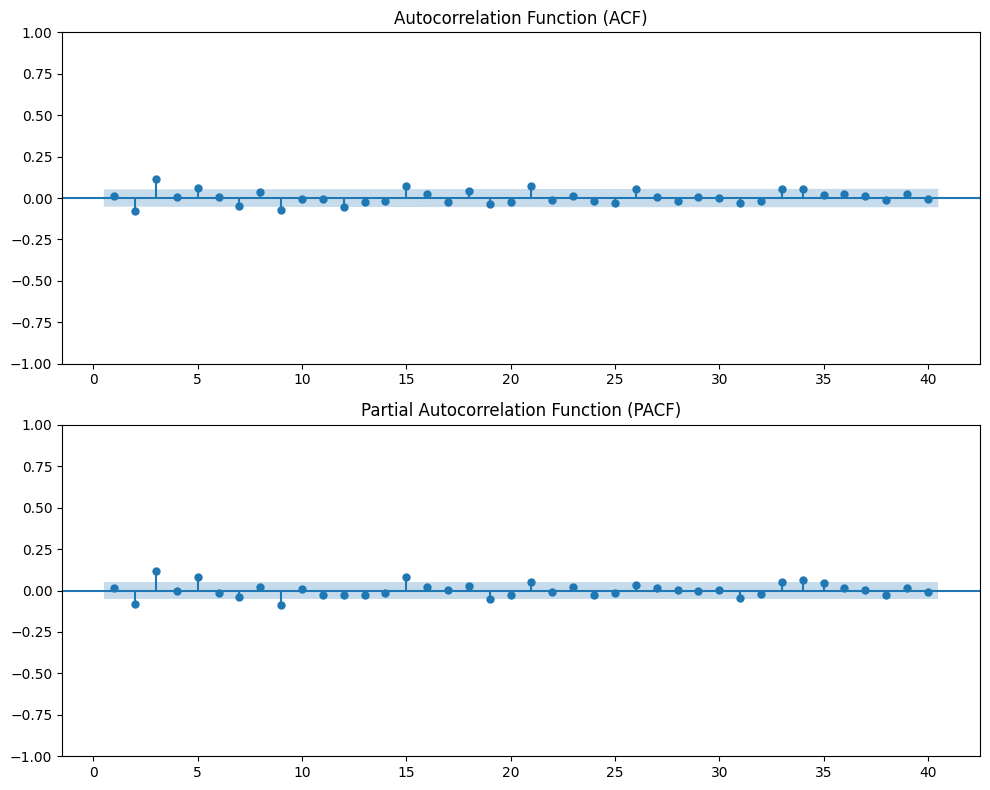

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

plot_acf(df["Perubahan%"], ax=ax[0], lags=40, zero=False)
ax[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(df["Perubahan%"], ax=ax[1], lags=40, zero=False, method='ywm')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [62]:
def acf_pacf_summary(series, nlags=40):
    series = series.dropna()
    N = len(series)
    threshold = 1.96 / np.sqrt(N)
    
    acf_vals = acf(series, nlags=nlags)
    pacf_vals = pacf(series, nlags=nlags, method='ywm')
    
    sig_acf = np.where(np.abs(acf_vals) > threshold)[0]
    sig_pacf = np.where(np.abs(pacf_vals) > threshold)[0]
    
    print(f"Significance threshold: ±{threshold:.3f}")
    print(f"Significant ACF lags: {sig_acf}")
    print(f"Significant PACF lags: {sig_pacf}")
    return acf_vals, pacf_vals

acf_vals, pacf_vals = acf_pacf_summary(df['Perubahan%'], nlags=40)


Significance threshold: ±0.052
Significant ACF lags: [ 0  2  3  5  9 15 21 26 33 34]
Significant PACF lags: [ 0  2  3  5  9 15 33 34]


# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [67]:
print("Check NA value")
print(df.isna().sum())

print("Check Duplicates")
print(df.duplicated().sum())

print("Terdapat missing value pada kolom Vol. namun akan dibiarkan karena kolom tersebut tidak digunakan")

Check NA value
Tanggal        0
Terakhir       0
Pembukaan      0
Tertinggi      0
Terendah       0
Vol.           3
Perubahan%     0
MA30          29
MA60          59
MA10           9
dtype: int64
Check Duplicates
0
Terdapat missing value pada kolom Vol. namun akan dibiarkan karena kolom tersebut tidak digunakan


In [65]:
data = df[["Terakhir", "Terendah", "Tertinggi"]].values

In [71]:
data

array([[6283.58, 6263.68, 6317.01],
       [6323.47, 6287.71, 6323.47],
       [6257.4 , 6252.64, 6300.44],
       ...,
       [8184.06, 8145.6 , 8231.88],
       [8163.88, 8144.08, 8215.55],
       [8274.95, 8214.61, 8280.18]])

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [72]:
np.save("scaled_stock_data.npy", scaled_data)

In [ ]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [73]:
scaled_data = np.load("scaled_stock_data.npy")

In [80]:
def create_sequences(data, time_steps=10, target_col_index=0):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])   # previous 60 days (all features)
        y.append(data[i, target_col_index])  # next day's Close
    X = np.array(X)
    y = np.array(y)
    np.save(f"X_timestep_{time_steps}", X)
    np.save(f"y_timestep_{time_steps}", y)
    print("Data saved successfully")


In [81]:
create_sequences(scaled_data, 10, 0)

Data saved successfully
